### Importing Libraries


In [1]:
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks, welch
import wfdb
from scipy.stats import skew, kurtosis
from typing import List, Dict, Tuple

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

### Defining Paths

In [255]:
# Define data path for the polysomnographic database
data_path = "C:\\Users\\likhi\\OneDrive\\Documents\\mit-bih-polysomnographic-database-1.0.0"


In [256]:
class SleepAnnotationParser:
    """Parser for sleep study annotation files with strict stage mapping"""
    def __init__(self):
        # Sleep stages mapping - strictly limited to database stages
        self.sleep_stages = {
            'W': 'Awake', 
            '1': 'Stage 1', 
            '2': 'Stage 2',
            '3': 'Stage 3', 
            '4': 'Stage 4', 
            'R': 'REM'
        }

        # Event map with proper categorization
        self.event_map = {
            'L': 'no apnea',
            'LA': 'no apnea', 
            'A': 'no apnea', 
            'MT': 'no apnea',
            'H': 'hypopneas',
            'HA': 'hypopneas',
            'OA': 'apneas',
            'X': 'apneas',
            'CA': 'apneas',
            'CAA': 'apneas'
        }

    def _parse_event_sequence(self, sequence: str) -> List[Tuple[str, str, bool]]:
        """
        Parse a sequence of events and sleep stages with strict stage checking
        """
        events = []
        current_pos = 0
        sequence = sequence.strip()
        sequence_length = len(sequence)
        current_stage = None
        
        while current_pos < sequence_length:
            try:
                current_char = sequence[current_pos]
                
                # Skip whitespace
                if current_char.isspace():
                    current_pos += 1
                    continue
                
                # Check for sleep stage
                if current_char in self.sleep_stages:
                    current_stage = self.sleep_stages[current_char]
                    events.append((None, current_stage, True))
                    current_pos += 1
                    continue
                
                # Try three-character events
                if current_pos + 3 <= sequence_length:
                    three_char = sequence[current_pos:current_pos + 3]
                    if three_char in self.event_map:
                        events.append((three_char, current_stage, False))
                        current_pos += 3
                        continue
                
                # Try two-character events
                if current_pos + 2 <= sequence_length:
                    two_char = sequence[current_pos:current_pos + 2]
                    if two_char in self.event_map:
                        events.append((two_char, current_stage, False))
                        current_pos += 2
                        continue
                
                # Try single-character events
                if current_char in self.event_map:
                    events.append((current_char, current_stage, False))
                    current_pos += 1
                else:
                    # Skip unrecognized character
                    current_pos += 1
                    
            except IndexError:
                break
                
        return events

    def parse_annotation_file(self, st_file: str, fs: int, duration: int) -> Tuple[np.ndarray, np.ndarray]:
        """Parse the annotation file with improved stage tracking"""
        events = np.full(duration, 'no apnea', dtype=object)
        stages = np.full(duration, 'Unknown', dtype=object)
        current_time = 0
        default_event_duration = int(fs * 5)  # 5 second default duration
        last_known_stage = None
        last_stage_time = 0
        
        try:
            if not os.path.exists(st_file):
                return events, stages
                
            with open(st_file, 'r', encoding='utf-8', errors='replace') as f:
                for line in f:
                    tokens = line.strip().split()
                    for token in tokens:
                        try:
                            # Try parsing as time value
                            time_value = float(token)
                            if last_known_stage is not None:
                                stages[last_stage_time:int(time_value * fs)] = last_known_stage
                            current_time = int(time_value * fs)
                            
                        except ValueError:
                            # Parse as event sequence
                            parsed_events = self._parse_event_sequence(token)
                            
                            for event_code, stage, is_stage_marker in parsed_events:
                                if current_time >= duration:
                                    continue
                                    
                                start_idx = current_time
                                end_idx = min(start_idx + default_event_duration, duration)
                                
                                # Handle events
                                if event_code is not None and event_code in self.event_map:
                                    events[start_idx:end_idx] = self.event_map[event_code]
                                
                                # Handle stages
                                if is_stage_marker and stage is not None:
                                    if last_known_stage is not None:
                                        stages[last_stage_time:start_idx] = last_known_stage
                                    stages[start_idx:end_idx] = stage
                                    last_known_stage = stage
                                    last_stage_time = end_idx
                                elif last_known_stage is not None:
                                    stages[start_idx:end_idx] = last_known_stage
                                    last_stage_time = end_idx
                                
                                current_time = end_idx
                
            # Fill remaining duration with last known stage
            if last_known_stage is not None and last_stage_time < duration:
                stages[last_stage_time:] = last_known_stage
                
        except Exception as e:
            print(f"Error parsing annotation file {st_file}: {str(e)}")
            
        return events, stages

def post_process_stages(stages: np.ndarray) -> np.ndarray:
    """
    Post-process stages to fill gaps between known stages
    """
    processed_stages = stages.copy()
    unknown_mask = (stages == 'Unknown')
    
    if np.any(unknown_mask):
        # Forward fill
        last_valid = None
        for i in range(len(stages)):
            if stages[i] != 'Unknown':
                last_valid = stages[i]
            elif last_valid is not None:
                processed_stages[i] = last_valid
        
        # Backward fill for any remaining unknowns
        last_valid = None
        for i in range(len(stages) - 1, -1, -1):
            if stages[i] != 'Unknown':
                last_valid = stages[i]
            elif last_valid is not None:
                processed_stages[i] = last_valid
    
    return processed_stages

def process_record(record_name: str, data_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Process a single record with stage statistics"""
    try:
        # Load record
        record = wfdb.rdrecord(os.path.join(data_path, record_name))
        signal_length = len(record.p_signal)
        
        # Parse annotations
        parser = SleepAnnotationParser()
        st_file = os.path.join(data_path, record_name + '.st')
        events, stages = parser.parse_annotation_file(st_file, record.fs, signal_length)
        
        # Post-process stages
        processed_stages = post_process_stages(stages)
        
        # Print stage distribution
        print(f"\nStage distribution for record {record_name}:")
        stage_counts = pd.Series(processed_stages).value_counts()
        print(stage_counts)
        
        return events, processed_stages
        
    except Exception as e:
        print(f"Error processing record {record_name}: {str(e)}")
        return np.array([]), np.array([])


def process_annotations(st_file: str, fs: int, window_size: int, overlap: float, total_duration: int) -> Tuple[np.ndarray, np.ndarray]:
    """Process annotations and return windowed events and sleep stages"""
    parser = SleepAnnotationParser()
    events, stages = parser.parse_annotation_file(st_file, fs, total_duration)
    window_samples = int(window_size * fs)
    step = int(window_samples * (1 - overlap))
    n_windows = (len(events) - window_samples) // step + 1
    windowed_events = np.full(n_windows, 'No Event', dtype=object)
    windowed_stages = np.full(n_windows, 'Unknown', dtype=object)
    for i in range(n_windows):
        start_idx = i * step
        end_idx = start_idx + window_samples
        window_events = events[start_idx:end_idx]
        unique_events, counts = np.unique(window_events, return_counts=True)
        event_mask = unique_events != 'No Event'
        if np.any(event_mask):
            unique_events = unique_events[event_mask]
            counts = counts[event_mask]
            windowed_events[i] = unique_events[np.argmax(counts)]
        window_stages = stages[start_idx:end_idx]
        unique_stages, counts = np.unique(window_stages, return_counts=True)
        stage_mask = unique_stages != 'Unknown'
        if np.any(stage_mask):
            unique_stages = unique_stages[stage_mask]
            counts = counts[stage_mask]
            windowed_stages[i] = unique_stages[np.argmax(counts)]
    return windowed_events, windowed_stages




In [257]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Apply a Butterworth bandpass filter."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)



In [258]:
def segment_signal(signal, fs, window_size, overlap):
    """Segment the signal into windows."""
    window_samples = int(window_size * fs)
    step = int(window_samples * (1 - overlap))
    n_windows = (len(signal) - window_samples) // step + 1
    windows = [signal[i * step:i * step + window_samples] for i in range(n_windows)]
    return np.array(windows)



In [259]:
def extract_features(windows, fs, windowed_events, windowed_stages):
    """Extract features from the ECG windows and include events and stages."""
    features = []
    for i, window in enumerate(windows):
        Central_Tendency = np.mean(window)
        Variability = np.var(window)
        Signal_Intensity = np.sum(window**2)
        skewness = skew(window)
        kurt = kurtosis(window)
        Amplitude_Range = np.ptp(window)
        RMS_Value = np.sqrt(np.mean(window**2))
        qrs_count = len(find_peaks(window)[0])
        f, Pxx = welch(window, fs)
        psd = np.sum(Pxx)
        event = windowed_events[i]
        Sleep_State_Transition = windowed_stages[i]
        
        rounded_features = np.round([Central_Tendency,Variability, Signal_Intensity, skewness, kurt, Amplitude_Range, RMS_Value, qrs_count, psd], 4)

        # Append rounded features with event and stage
        features.append([*rounded_features, event, Sleep_State_Transition])
    return np.array(features)



In [260]:
def load_and_process_record(record_name):
    """Load the record, process the ECG signal, and include sleep stages and events."""
    record = wfdb.rdrecord(os.path.join(data_path, record_name))
    fs = record.fs
    ecg_signal = record.p_signal[:, 0]
    filtered_signal = butter_bandpass_filter(ecg_signal, 0.5, 50, fs)
    window_size = 30
    overlap = 0.5
    windows = segment_signal(filtered_signal, fs, window_size, overlap)
    st_file = os.path.join(data_path, record_name + '.st')
    total_duration = len(ecg_signal)
    windowed_events, windowed_stages = process_annotations(st_file, fs, window_size, overlap, total_duration)
    features = extract_features(windows, fs, windowed_events, windowed_stages)
    return features

# Main execution: process all records in the dataset
all_features = []
for file in os.listdir(data_path):
    if file.endswith('.dat'):
        record_name = file.replace('.dat', '')
        features = load_and_process_record(record_name)
        all_features.append(features)

# Convert the results into a single array for further analysis
all_features = np.concatenate(all_features, axis=0)
df_features = pd.DataFrame(all_features, columns=['Central_Tendency', 'Variability', 'Signal_Intensity', 'skewness', 'kurtosis', 
                                                  'Amplitude_Range', 'RMS_Value', 'qrs_count', 'psd', 'event', 'Sleep_State_Transition'])

# Save features to CSV for analysis
df_features.to_csv('processed_features_with_annotations.csv', index=False)

df_features.head()

# Count the occurrences of each unique item in the 'event' column
print("Count of each unique item in 'event':")
print(df_features['event'].value_counts())

# Count the occurrences of each unique item in the 'sleep_stage' column
print("\nCount of each unique item in 'Sleep_State_Transition':")
print(df_features['Sleep_State_Transition'].value_counts())

Count of each unique item in 'event':
event
no apnea     17400
apneas        3115
hypopneas       15
Name: count, dtype: int64

Count of each unique item in 'Sleep_State_Transition':
Sleep_State_Transition
Awake      8127
Stage 2    6804
Stage 1    3462
REM        1430
Stage 3     503
Stage 4     204
Name: count, dtype: int64


In [261]:
random_rows = df_features.sample(n=20, random_state=42) 

print(random_rows)


      Central_Tendency Variability Signal_Intensity skewness kurtosis  \
1272            0.0002      0.0112          84.1786  -0.2054   5.2954   
3222           -0.0013      0.0734         550.7128   2.6703  18.0881   
6423            0.0006      0.0215         161.6137   3.9428  19.9768   
18118           0.0001      0.0375         281.0781   3.0755  13.9031   
12456           0.0002      0.1688        1265.7575   2.8478  19.4324   
6956           -0.0008      0.0681         511.0893   2.7772  12.6288   
5921            0.0002      0.0311         233.3883   4.5075  25.1333   
15102           0.0003      0.0299         224.4975   0.2223  11.4557   
11075          -0.0001      0.0143         106.9247   1.9287  13.5935   
14359          -0.0007      0.0226         169.2045  -1.3934   6.2932   
3230            0.0004      0.0735         550.9321   2.7249  18.7674   
8960            0.0002        0.03         225.1387   4.4803   25.481   
3733           -0.0006      0.0461         345.8332

In [262]:
df_features.head(10)

,Central_Tendency,Variability,Signal_Intensity,skewness,kurtosis,Amplitude_Range,RMS_Value,qrs_count,psd,event,Sleep_State_Transition
0,0.0002,0.0173,129.6703,2.6112,16.3808,1.3613,0.1315,715.0,0.0178,no apnea,Stage 4
1,-0.0001,0.0167,125.4903,2.6681,16.8918,1.3485,0.1294,712.0,0.0172,no apnea,Stage 4
2,0.0005,0.0172,129.3335,2.6218,16.302,1.3652,0.1313,698.0,0.0175,no apnea,Stage 4
3,0.0,0.0172,129.2909,2.6072,16.2717,1.3673,0.1313,713.0,0.0178,no apnea,Stage 4
4,-0.0005,0.0166,124.4723,2.6814,16.9959,1.3579,0.1288,736.0,0.0177,no apnea,Stage 4
5,0.0001,0.0168,126.2908,2.6654,16.8691,1.3637,0.1298,752.0,0.0163,no apnea,Stage 4
6,-0.0001,0.0169,126.6169,2.6707,16.9283,1.3777,0.1299,754.0,0.0175,no apnea,Stage 4
7,0.0003,0.0168,125.6641,2.636,16.8752,1.3806,0.1294,734.0,0.0171,no apnea,Stage 4
8,0.0002,0.0168,125.7783,2.5903,16.7111,1.3611,0.1295,725.0,0.0171,no apnea,Stage 4
9,-0.0002,0.017,127.7317,2.6303,16.6721,1.353,0.1305,729.0,0.0175,no apnea,Stage 4


In [263]:
df_features.tail(10)

,Central_Tendency,Variability,Signal_Intensity,skewness,kurtosis,Amplitude_Range,RMS_Value,qrs_count,psd,event,Sleep_State_Transition
20520,0.0003,0.0115,85.9593,3.2357,13.8701,0.8206,0.1071,496.0,0.0121,no apnea,Awake
20521,-0.0002,0.0117,87.4579,3.1912,13.6162,0.8457,0.108,489.0,0.0123,no apnea,Awake
20522,-0.0002,0.0121,90.9084,3.2214,13.6844,0.855,0.1101,492.0,0.0129,no apnea,Awake
20523,0.0003,0.0109,82.1137,3.4048,15.2315,0.8448,0.1046,517.0,0.0113,no apnea,Awake
20524,-0.0,0.0112,83.6652,3.3295,14.632,0.8474,0.1056,518.0,0.0117,no apnea,Awake
20525,0.0,0.012,89.8978,3.225,13.7478,0.8474,0.1095,510.0,0.0126,no apnea,Awake
20526,-0.0003,0.0112,84.1199,3.297,14.3973,0.8423,0.1059,532.0,0.012,no apnea,Awake
20527,0.0001,0.0119,89.0594,3.0949,12.8377,0.8938,0.109,681.0,0.0123,no apnea,Awake
20528,0.0004,0.0122,91.1618,2.9795,11.8326,0.8938,0.1102,773.0,0.0127,no apnea,Awake
20529,-0.0001,0.0102,76.7873,3.1394,12.9465,0.8217,0.1012,759.0,0.0106,no apnea,Awake


In [264]:
# Display the shape of the DataFrame
print("Shape of the DataFrame:", df_features.shape)

Shape of the DataFrame: (20530, 11)


In [265]:
# Display data types of each column
print("Data Types:\n", df_features.dtypes)

Data Types:
 Central_Tendency          object
Variability               object
Signal_Intensity          object
skewness                  object
kurtosis                  object
Amplitude_Range           object
RMS_Value                 object
qrs_count                 object
psd                       object
event                     object
Sleep_State_Transition    object
dtype: object


In [266]:
# Checking Missing Values

# Get total missing values and percentage for each column
missing_values = pd.DataFrame({
    'Total Missing': df_features.isnull().sum(),
    'Percentage Missing': (df_features.isnull().sum() / len(df_features) * 100).round(2)
})

# Sort by percentage of missing values in descending order
missing_values = missing_values.sort_values('Percentage Missing', ascending=False)

# Add a column for data type of each feature
missing_values['Data Type'] = df_features.dtypes

# Display the missing values information
print("\nMissing Values Analysis:")
print("-" * 70)
print(missing_values)

# Get total number of missing values in entire dataset
total_missing = df_features.isnull().sum().sum()
total_cells = df_features.size
missing_percentage = (total_missing / total_cells * 100).round(2)

print("\nOverall Dataset Summary:")
print("-" * 70)
print(f"Total number of missing values: {total_missing}")
print(f"Total number of cells in dataset: {total_cells}")
print(f"Percentage of missing values in entire dataset: {missing_percentage}%")

# Check if there are any rows with all missing values
rows_all_missing = df_features.isnull().all(axis=1).sum()
if rows_all_missing > 0:
    print(f"\nNumber of rows with all values missing: {rows_all_missing}")

# Check if there are any rows with at least one missing value
rows_any_missing = df_features.isnull().any(axis=1).sum()
if rows_any_missing > 0:
    print(f"Number of rows with at least one missing value: {rows_any_missing}")


Missing Values Analysis:
----------------------------------------------------------------------
                        Total Missing  Percentage Missing Data Type
Central_Tendency                    0                 0.0    object
Variability                         0                 0.0    object
Signal_Intensity                    0                 0.0    object
skewness                            0                 0.0    object
kurtosis                            0                 0.0    object
Amplitude_Range                     0                 0.0    object
RMS_Value                           0                 0.0    object
qrs_count                           0                 0.0    object
psd                                 0                 0.0    object
event                               0                 0.0    object
Sleep_State_Transition              0                 0.0    object

Overall Dataset Summary:
-------------------------------------------------------------

In [267]:
# Check for duplicate rows
duplicates = df_features.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 0


In [268]:
# Data Type Conversion
# Convert numerical columns to float type
numeric_columns = ['Central_Tendency', 'Variability', 'Signal_Intensity', 
                  'skewness', 'kurtosis', 'Amplitude_Range', 'RMS_Value', 
                  'qrs_count', 'psd']

for column in numeric_columns:
    df_features[column] = df_features[column].astype(float)
    


In [269]:
# Display unique values in each column
for column in df_features.select_dtypes(include=['object']).columns:
    print(f"Unique values in {column}:\n", df_features[column].unique())

Unique values in event:
 ['no apnea' 'hypopneas' 'apneas']
Unique values in Sleep_State_Transition:
 ['Stage 4' 'Stage 3' 'Stage 2' 'Awake' 'Stage 1' 'REM']


In [270]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns to normalize
numeric_columns = [
    'Central_Tendency', 'Variability', 'Signal_Intensity', 'skewness', 
    'kurtosis', 'Amplitude_Range', 'RMS_Value', 'qrs_count', 'psd'
]

# Initialize the scaler
scaler = StandardScaler()

# Apply normalization and update the DataFrame
df_features[numeric_columns] = scaler.fit_transform(df_features[numeric_columns])

# Verify normalization
print(df_features.head())


   Central_Tendency  Variability  Signal_Intensity  skewness  kurtosis  \
0          0.539133    -0.441982         -0.442321 -0.107277 -0.080949   
1         -0.270868    -0.461343         -0.460305 -0.074826 -0.016532   
2          1.349134    -0.445209         -0.443770 -0.101232 -0.090883   
3         -0.000868    -0.445209         -0.443954 -0.109558 -0.094703   
4         -1.350870    -0.464570         -0.464685 -0.067240 -0.003409   

   Amplitude_Range  RMS_Value  qrs_count       psd     event  \
0        -0.452741  -0.619509   0.712808 -0.442596  no apnea   
1        -0.472793  -0.656510   0.687782 -0.461222  no apnea   
2        -0.446631  -0.623033   0.570995 -0.451909  no apnea   
3        -0.443341  -0.623033   0.696124 -0.442596  no apnea   
4        -0.458067  -0.667081   0.887989 -0.445700  no apnea   

  Sleep_State_Transition  
0                Stage 4  
1                Stage 4  
2                Stage 4  
3                Stage 4  
4                Stage 4  


In [271]:
# Label Encoding for Target Variables
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder objects
event_encoder = LabelEncoder()
sleep_state_encoder = LabelEncoder()

# Perform label encoding on target variables
df_features['event'] = event_encoder.fit_transform(df_features['event'])
df_features['Sleep_State_Transition'] = sleep_state_encoder.fit_transform(df_features['Sleep_State_Transition'])


df_features.head()


,Central_Tendency,Variability,Signal_Intensity,skewness,kurtosis,Amplitude_Range,RMS_Value,qrs_count,psd,event,Sleep_State_Transition
0,0.539133,-0.441982,-0.442321,-0.107277,-0.080949,-0.452741,-0.619509,0.712808,-0.442596,2,5
1,-0.270868,-0.461343,-0.460305,-0.074826,-0.016532,-0.472793,-0.656510,0.687782,-0.461222,2,5
2,1.349134,-0.445209,-0.443770,-0.101232,-0.090883,-0.446631,-0.623033,0.570995,-0.451909,2,5
3,-0.000868,-0.445209,-0.443954,-0.109558,-0.094703,-0.443341,-0.623033,0.696124,-0.442596,2,5
4,-1.350870,-0.464570,-0.464685,-0.067240,-0.003409,-0.458067,-0.667081,0.887989,-0.445700,2,5


In [272]:
df_features.dtypes

Central_Tendency          float64
Variability               float64
Signal_Intensity          float64
skewness                  float64
kurtosis                  float64
Amplitude_Range           float64
RMS_Value                 float64
qrs_count                 float64
psd                       float64
event                       int32
Sleep_State_Transition      int32
dtype: object

### Exploratory Data Analysis

In [273]:
# Display summary statistics
summary_statistics = df_features.describe()
print(summary_statistics)

       Central_Tendency   Variability  Signal_Intensity      skewness  \
count      2.053000e+04  2.053000e+04      2.053000e+04  2.053000e+04   
mean      -2.128513e-17  1.052143e-16      1.107519e-17 -8.860153e-17   
std        1.000024e+00  1.000024e+00      1.000024e+00  1.000024e+00   
min       -1.674089e+01 -1.000215e+00     -1.000055e+00 -3.574114e+00   
25%       -5.408688e-01 -5.355588e-01     -5.343566e-01 -6.417289e-01   
50%       -8.679994e-04 -9.994394e-02     -9.862585e-02  4.839328e-02   
75%        5.391328e-01  2.453211e-01      2.455409e-01  9.275355e-01   
max        1.889916e+01  4.879863e+01      4.879786e+01  5.266328e+00   

           kurtosis  Amplitude_Range     RMS_Value     qrs_count  \
count  2.053000e+04     2.053000e+04  2.053000e+04  2.053000e+04   
mean  -4.430076e-16    -5.094588e-16  2.104286e-16  3.654813e-16   
std    1.000024e+00     1.000024e+00  1.000024e+00  1.000024e+00   
min   -2.163821e+00    -2.561088e+00 -2.897678e+00 -2.707397e+00   
25

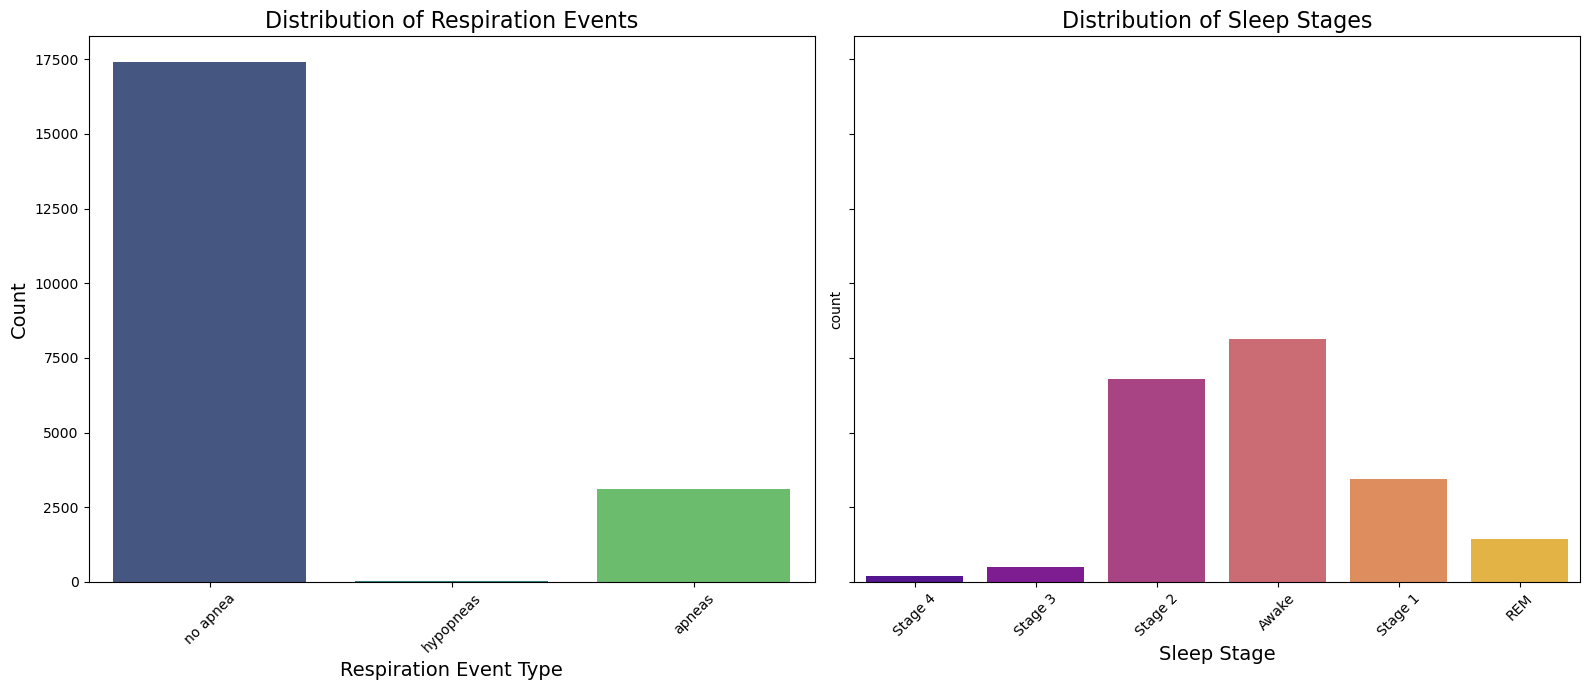

In [274]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a mapping of label-encoded values to their original names
event_labels = {index: label for index, label in enumerate(event_encoder.classes_)}
sleep_state_labels = {index: label for index, label in enumerate(sleep_state_encoder.classes_)}

# Map the original names back to the columns for visualization
df_features['event_original'] = df_features['event'].map(event_labels)
df_features['Sleep_State_Transition_original'] = df_features['Sleep_State_Transition'].map(sleep_state_labels)

# Set an impressive color palette
sns.set_palette("coolwarm")

# Create a figure with subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# Plot the distribution of the `event` column
sns.countplot(
    data=df_features, 
    x='event_original', 
    ax=axes[0], 
    palette="viridis"
)
axes[0].set_title("Distribution of Respiration Events", fontsize=16)
axes[0].set_xlabel("Respiration Event Type", fontsize=14)
axes[0].set_ylabel("Count", fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Plot the distribution of the `Sleep_State_Transition` column
sns.countplot(
    data=df_features, 
    x='Sleep_State_Transition_original', 
    ax=axes[1], 
    palette="plasma"
)
axes[1].set_title("Distribution of Sleep Stages", fontsize=16)
axes[1].set_xlabel("Sleep Stage", fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()



In [253]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

#######################
# 1. HMM Model Architecture
#######################

class SleepApneaHMM:
    def __init__(self):
        """
        Initialize HMM architecture with:
        - Hidden States: Sleep stages (W,1,2,3,4,R) - 6 states
        - Observations: Physiological signals (9 features)
        - Emission Distribution: Gaussian
        - Labels: Respiration events (no apnea, hypopneas, apneas)
        """
        # Number of hidden states (sleep stages: W,1,2,3,4,R)
        self.n_states = 6
       
        # Initialize the base HMM model
        self.model = hmm.GaussianHMM(
            n_components=self.n_states,
            covariance_type="full",
            n_iter=1000,
            random_state=42
        )
       
        # Initialize preprocessing tools
        self.scaler = StandardScaler()
        self.event_encoder = LabelEncoder()
        self.stage_encoder = LabelEncoder()
       
        # Store mappings between states and events
        self.state_event_mapping = None

#######################
# 2. Learning Process
#######################

def train_hmm(model, data_path):
    """
    Implement learning process for classifying respiration events
    """
    # Load and preprocess data
    df = pd.read_csv(data_path)
   
    # Extract features and labels
    feature_cols = ['Central_Tendency', 'Variability', 'Signal_Intensity', 'skewness', 'kurtosis', 
                    'Amplitude_Range', 'RMS_Value', 'qrs_count', 'psd']
    X = df[feature_cols].values
   
    # Encode categorical variables
    events = model.event_encoder.fit_transform(df['event'])
    stages = model.stage_encoder.fit_transform(df['Sleep_State_Transition'])
   
    # Scale features
    X_scaled = model.scaler.fit_transform(X)
   
    # Split data
    X_train, X_test, events_train, events_test, stages_train, stages_test = train_test_split(
        X_scaled, events, stages, test_size=0.2, random_state=42
    )
   
    print("Starting HMM training process...")
   
    # Train the HMM model
    model.model.fit(X_train)
   
    # Learn state-event mapping
    predicted_states = model.model.predict(X_train)
    state_event_mapping = np.zeros((model.n_states, len(set(events))))
   
    for state in range(model.n_states):
        state_mask = predicted_states == state
        if np.any(state_mask):
            event_counts = np.bincount(events_train[state_mask],
                                     minlength=len(set(events)))
            state_event_mapping[state] = event_counts / np.sum(event_counts)
   
    model.state_event_mapping = state_event_mapping
   
    print("Training completed.")
    print(f"Model score: {model.model.score(X_train)}")
   
    return X_test, events_test, stages_test

#######################
# 3. Evaluation Process
#######################

def evaluate_hmm(model, X_test, true_events, true_stages):
    """
    Implement evaluation process for classifying respiration events
    """
    print("\nStarting evaluation process...")
   
    # Predict states and events
    predicted_states = model.model.predict(X_test)
    predicted_events = np.array([np.argmax(model.state_event_mapping[state])
                               for state in predicted_states])
   
    # Evaluate event prediction
    print("\nRespiration Event Classification Report:")
    print(classification_report(
        true_events,
        predicted_events,
        target_names=model.event_encoder.classes_
    ))
   
    # Calculate and print event classification accuracy
    event_accuracy = accuracy_score(true_events, predicted_events)
    print(f"Event Classification Accuracy: {event_accuracy * 100:.2f}%")
   
    # Create confusion matrix for events
    event_cm = confusion_matrix(true_events, predicted_events)
    plt.figure(figsize=(10, 8))
    sns.heatmap(event_cm,
                annot=True,
                fmt='d',
                xticklabels=model.event_encoder.classes_,
                yticklabels=model.event_encoder.classes_)
    plt.title('Confusion Matrix - Respiration Events')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
   
    return predicted_states, predicted_events

#######################
# 4. Decoding Process
#######################

def decode_sleep_stages(model, X_test, predicted_states, true_stages):
    """
    Implement decoding process for predicting sequences of sleep stages
    """
    print("\nStarting decoding process for sleep stages...")
   
    # Get the most likely state sequence using Viterbi algorithm
    viterbi_states = model.model.predict(X_test)
   
    # Print sleep stage classification report
    print("\nSleep Stage Classification Report:")
    print(classification_report(
        true_stages,
        viterbi_states,
        target_names=model.stage_encoder.classes_
    ))
   
    # Calculate and print sleep stage classification accuracy
    stage_accuracy = accuracy_score(true_stages, viterbi_states)
    print(f"Sleep Stage Classification Accuracy: {stage_accuracy * 100:.2f}%")
   
    # Create confusion matrix for sleep stages
    stage_cm = confusion_matrix(true_stages, viterbi_states)
    plt.figure(figsize=(10, 8))
    sns.heatmap(stage_cm,
                annot=True,
                fmt='d',
                xticklabels=model.stage_encoder.classes_,
                yticklabels=model.stage_encoder.classes_)
    plt.title('Confusion Matrix - Sleep Stages')
    plt.ylabel('True Stage')
    plt.xlabel('Predicted Stage')
    plt.show()
   
    # Analyze state transitions
    transition_matrix = model.model.transmat_
    plt.figure(figsize=(10, 8))
    sns.heatmap(transition_matrix,
                annot=True,
                fmt='.2f',
                xticklabels=model.stage_encoder.classes_,
                yticklabels=model.stage_encoder.classes_)
    plt.title('State Transition Probabilities')
    plt.ylabel('From Stage')
    plt.xlabel('To Stage')
    plt.show()
   
    return viterbi_states

def main():
    # Initialize model
    print("1. Initializing HMM Model Architecture...")
    model = SleepApneaHMM()
   
    # Train model
    print("\n2. Starting Learning Process...")
    X_test, events_test, stages_test = train_hmm(model, 'processed_features_with_annotations.csv')
   
    # Evaluate model
    print("\n3. Starting Evaluation Process...")
    predicted_states, predicted_events = evaluate_hmm(model, X_test, events_test, stages_test)
   
    # Decode sleep stages
    print("\n4. Starting Decoding Process...")
    viterbi_states = decode_sleep_stages(model, X_test, predicted_states, stages_test)
   
    # Print example sequence
    print("\nExample Sequence (first 10 windows):")
    print("True Events:", model.event_encoder.inverse_transform(events_test[:10]))
    print("Predicted Events:", model.event_encoder.inverse_transform(predicted_events[:10]))
    print("True Stages:", model.stage_encoder.inverse_transform(stages_test[:10]))
    print("Predicted Stages:", model.stage_encoder.inverse_transform(viterbi_states[:10]))

if __name__ == "__main__":
    main()

1. Initializing HMM Model Architecture...

2. Starting Learning Process...


KeyError: "['Signal_Intensity', 'kurtosis', 'qrs_count'] not in index"